In [1]:
import numpy as np
import rebound as rb
from matplotlib import pyplot as plt
import sympy as sp
import celmech as cm

from celmech.disturbing_function import get_fg_coefficients

from celmech.poisson_series import PoissonSeries,PSTerm

# data from exoplanet archive

In [3]:
import requests
import pandas as pd
from io import StringIO

TAP_URL = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync"

def fetch_system(system_name, prefer_composite=True):
    """
    Return stellar + planetary parameters for a given host, using the
    NASA Exoplanet Archive TAP service.

    Parameters
    ----------
    system_name : str
        Host star identifier exactly as it appears in the Archive
        (e.g. 'TOI-178', 'Kepler-223').
    prefer_composite : bool, default True
        If True, try the PSCompPars table first and fall back to PS.
        If False, go straight to the PS table.

    Returns
    -------
    star : dict
        Stellar parameters taken from the first (or only) row.
    planets : pandas.DataFrame
        Planet–level parameters for all rows that match.
    table_used : str
        Either 'pscomppars' or 'ps'.
    """
    tables_to_try = ["pscomppars", "ps"] if prefer_composite else ["ps"]

    for table in tables_to_try:
        query = f"""
            SELECT hostname, pl_name,
                   pl_orbper, pl_orbsmax, pl_orbeccen, pl_orbincl,
                   pl_bmasse, pl_radj,
                   st_mass, st_rad, st_teff, st_logg, st_met
            FROM {table}
            WHERE hostname = '{system_name}'
        """
        r = requests.get(TAP_URL, params={"query": query, "format": "csv"})
        if r.status_code != 200:
            raise RuntimeError(f"TAP error {r.status_code}: {r.text[:250]}")
        df = pd.read_csv(StringIO(r.text))
        if len(df):                      # success!
            star_cols = ["hostname","st_mass","st_rad","st_teff","st_logg","st_met"]
            star = df.iloc[0][star_cols].to_dict()
            planets = df.drop(columns=[c for c in star_cols if c != "hostname"])
            return star, planets, table

    raise ValueError(f"No rows returned for host '{system_name}' in any table.")

# ---- example ---------------------------------------------------------------
if __name__ == "__main__":
    for host in ("Kepler-223", "TOI-178"):
        star, planets, tbl = fetch_system(host)
        print(f"\n{host}: pulled from {tbl}")
        print("Star:", {k: v for k, v in star.items() if k != 'hostname'})
        print(planets[["pl_name","pl_orbper","pl_bmasse"]].head())



Kepler-223: pulled from pscomppars
Star: {'st_mass': 1.125, 'st_rad': 1.72, 'st_teff': 5803.0, 'st_logg': 4.46, 'st_met': 0.1}
        pl_name  pl_orbper  pl_bmasse
0  Kepler-223 d   14.78869        8.0
1  Kepler-223 b    7.38449        7.4
2  Kepler-223 c    9.84564        5.1
3  Kepler-223 e   19.72567        4.8

TOI-178: pulled from pscomppars
Star: {'st_mass': 0.65, 'st_rad': 0.651, 'st_teff': 4316.0, 'st_logg': 4.45, 'st_met': -0.23}
     pl_name  pl_orbper  pl_bmasse
0  TOI-178 b   1.914558       1.50
1  TOI-178 c   3.238450       4.77
2  TOI-178 d   6.557700       3.01
3  TOI-178 e   9.961881       3.86
4  TOI-178 f  15.231915       7.72


# get ttv posteriors

In [1]:
from resonantstate.data_download  import get_metadata_observations, download_observations_samples
from resonantstate.analyse_samples import *

from corner import hist2d

In [57]:
df_all_obs = get_metadata_observations()
target = "TOI-178"
df_selected = df_all_obs[df_all_obs["star_name"].isin([target])]

#download_destination_path = "downloaded_observtions_samples/"
download_destination_path = None
df_list = download_observations_samples(df_selected, download_destination_path)

for k,v in df_list[0].items():
    if k == "samples":
        print(f"{k}:\t...")
    else:
        print(f"{k}:\t{v}")
df = df_list[0]['samples']
df.head(3)

samples_name:	TOI-178_0
planets_list:	['TOI-178 c', 'TOI-178 d', 'TOI-178 e', 'TOI-178 f', 'TOI-178 g']
samples:	...
readme:	The log-uniform mass priors are set between 1e-7 and 1e-2 M_planet_mstar, the eccentricity log_uniform priors are set between 1e-4 and 1e0.

The short cadence data was used whenever available.


additional_info:	None
author_name:	Leleu
star_name:	TOI-178
analysis_id:	0
contact_email:	adrien.leleu@unige.ch
default:	0
robustness:	[1, 1, 1, 1, 1]
initial_condition_date_BJD:	2458352.55018382
nb_planets:	5
gaia_id:	DR2 2318295979126499200
mass_prior:	log-uniform
eccentricity_prior:	uniform
transit_definition:	z+
methods:	photo-dynamics, RV
instruments:	TESS, NGTS, CHEOPS, ESPRESSO
bibtex:	2024A&A...688A.211L
code_used:	2023A&A...669A.117L
other_remarks:	


,sample_index,mean_longitude_deg_0,period_days_0,k_0,h_0,inclination_deg_0,longitude_of_ascending_node_deg_0,mass_planet_star_ratio_0,radius_planet_star_ratio_0,mean_longitude_deg_1,...,mean_longitude_deg_4,period_days_4,k_4,h_4,inclination_deg_4,longitude_of_ascending_node_deg_4,mass_planet_star_ratio_4,radius_planet_star_ratio_4,mass_star_m_sun,radius_star_r_sun
0,0.0,54.880736,3.238498,-0.000684,0.005031,90.0,0.0,0.000019,0.023681,28.293381,...,55.327046,20.722721,-0.000219,0.000622,90.0,0.0,0.000020,0.041040,0.604143,0.649537
1,1.0,54.470022,3.238444,0.001137,-0.001167,90.0,0.0,0.000021,0.023758,28.712716,...,55.216497,20.721957,0.001173,-0.003016,90.0,0.0,0.000019,0.040321,0.694614,0.667711
2,2.0,54.895957,3.238481,-0.000189,-0.000803,90.0,0.0,0.000027,0.024694,28.364136,...,54.971445,20.723098,0.002435,0.005125,90.0,0.0,0.000019,0.040945,0.627369,0.658202


In [58]:
for i in range(df_list[0]['nb_planets']):
    df[f'z_{i}'] = df[f'k_{i}'] + 1j * df[f'h_{i}'] 

for i in range(df_list[0]['nb_planets']-1):
    pratio = df[f'period_days_{i+1}']/df[f'period_days_{i}']
    jres = int(np.round(1+1/(pratio.median()-1)))
    Delta = (jres-1)*pratio/jres - 1
    f,g = get_fg_coefficients(jres,1)
    denom = np.sqrt(f*f+g*g)
    df[f'Z_{i}_{i+1}'] = (f * df[f'z_{i}'] + df[f'z_{i+1}']) / denom

hist2d(
    df['mass_planet_star_ratio_4'].values/3e-6 , 
    np.abs(df['Z_3_4']).values,
    plot_density=False,
    levels=[0.68,0.95],
    contour_kwargs={'linewidths':[2,3]}
)

In [4]:
import requests
import pandas as pd
from io import StringIO


from resonant_chains import get_chain_rebound_sim
def get_chain_hpert(resonances, max_order,max_order_dl = 1):
    sim = get_chain_rebound_sim(resonances,masses)
    pvars = cm.Poincare.from_Simulation(sim)
    pham = cm.PoincareHamiltonian(pvars)
    periods = []
    period = 1
    periods.append(period)
    for j,k in resonances:
        period *= j/sp.S(j-k)
        periods.append(period)
    hpert_series_terms = []

    ei_order = lambda k,nu: np.sum(np.abs(k[2:])) + 2*np.sum(nu)
    for i1,p1 in enumerate(periods):
        for i2,p2 in zip(range(i1+1,len(periods)),periods[i1+1:]):
            pratio = p2/p1
            p,q = int(sp.numer(pratio)),int(sp.numer(pratio) - sp.denom(pratio))
            resonant_terms = cm.disturbing_function.list_resonance_terms(p,q,max_order = max_order)
            if len(resonant_terms)>0:
                print("adding terms for {}:{} MMR between {} and {}".format(p,p-q,i1+1,i2+1))
            for k,nu in resonant_terms:
                hpert_series_terms += cm.poisson_series.DFTerm_as_PSterms(pham,i1+1,i2+1,k,nu,(0,0))
                if ei_order(k,nu) <= max_order_dl:
                    hpert_series_terms += cm.poisson_series.DFTerm_as_PSterms(pham,i1+1,i2+1,k,nu,(1,0))
                    hpert_series_terms += cm.poisson_series.DFTerm_as_PSterms(pham,i1+1,i2+1,k,nu,(0,1))

    secular_terms = cm.disturbing_function.list_secular_terms(min_order=0,max_order = max_order)
    for k,nu in secular_terms:
        for i1 in range(1,sim.N):
            for i2 in range(i1+1,sim.N):
                hpert_series_terms += cm.poisson_series.DFTerm_as_PSterms(pham,i1,i2,k,nu,(0,0))
                if ei_order(k,nu) <= max_order_dl:
                    hpert_series_terms += cm.poisson_series.DFTerm_as_PSterms(pham,i1,i2,k,nu,(1,0))
                    hpert_series_terms += cm.poisson_series.DFTerm_as_PSterms(pham,i1,i2,k,nu,(0,1))
    return PoissonSeries.from_PSTerms(hpert_series_terms)
from celmech.nbody_simulation_utilities import add_canonical_heliocentric_elements_particle
import rebound as rb
import celmech as cm
def Deltas_to_pvars(Deltas,resonances,masses):
    sim = rb.Simulation()
    sim.add(m=1)
    Period = 1
    add_canonical_heliocentric_elements_particle(masses[0],{'a' : Period**(2/3)},sim)
    for Delta,mass,pq in zip(Deltas,masses[1:],resonances):
        p,q = pq
        Period *= (1+Delta)*p/(p-q)
        add_canonical_heliocentric_elements_particle(mass,{'a' : Period**(2/3)},sim)
    sim.move_to_com()

    return cm.Poincare.from_Simulation(sim)

In [15]:
i_order

array([0, 1, 2, 3, 4, 5])

In [16]:
star_data, planet_data, tbl = fetch_system("TOI-178")
i_order = planet_data['pl_orbper'].argsort().values
i_order = np.delete(i_order,0) # innermost planet doesn't participate in chain
masses = 3e-6*planet_data['pl_bmasse'].values[i_order] / star_data['st_mass']
periods = planet_data['pl_orbper'].values[i_order]
jres = np.round(1+1/(periods[1:]/periods[:-1]-1)).astype(int)
resonances = [(j,1) for j in jres]

Deltas_obs = [(j-1)*p2/p1/j-1 for j,p1,p2 in zip(jres,periods[:-1],periods[1:])];

In [19]:
print(jres,Deltas_obs)

[2 3 3 4] [0.012475103830536183, 0.012741357488143867, 0.01934664748555015, 0.019709274900759244]


In [22]:
from resonant_chains import ResonantChainPoissonSeries, newton_solve2

In [ ]:
pvars = Deltas_to_pvars(Deltas_obs,resonances,masses)

hpert = get_chain_hpert(resonances,3,1)

rc = ResonantChainPoissonSeries(resonances,masses,hpert)

In [29]:
gcds = []
for res1,res2, in zip(resonances,resonances[1:]):
    j1,k1 = res1
    j2,k2 = res2
    k3br = np.array([k1-j1,j1,0]) - np.array([0,k2-j2,j2])  
    print(k3br,np.gcd.reduce(k3br))
    gcds.append(np.gcd.reduce(k3br))
gcds = np.array(gcds)

rvars,dK2 = rc.pvars_to_real_vars(pvars)
guess = rvars
guess[rc.N_planar:rc.N_planar+rc.M] = np.pi / gcds 
rc.dK2 = dK2

eqC = newton_solve2(rc.planar_flow_and_jacobian,guess)

eigs = np.linalg.eigvals(rc.planar_jacobian(eqC))
print(np.all(np.isclose(np.real(eigs),0)))
Tmax = np.max(2*np.pi/np.imag(eigs))

[-1  4 -3] 1
[-2  5 -3] 1
[-2  6 -4] 2


In [31]:
from celmech.lie_transformations import FirstOrderGeneratingFunction
print("correcting...")
chi_static = FirstOrderGeneratingFunction(Deltas_to_pvars([0 for _ in jres],resonances,masses))
Npl = rc.N_planar
for i in range(1,Npl):
    chi_static.add_zeroth_order_term(i,i+1)    
    for k in range(1,5):
        chi_static.add_cosine_term(
            [jres[i-1]+k,1-jres[i-1]-k,-1,0,0,0],
            indexIn=i,
            indexOut=i+1
        )
        chi_static.add_cosine_term(
            [jres[i-1]-k,1-jres[i-1]+k,-1,0,0,0],
            indexIn=i,
            indexOut=i+1
        )
        chi_static.add_cosine_term(
            [jres[i-1]+k,1-jres[i-1]-k,0,-1,0,0],
            indexIn=i,
            indexOut=i+1
        )
        chi_static.add_cosine_term(
            [jres[i-1]-k,1-jres[i-1]+k,0,-1,0,0],
            indexIn=i,
            indexOut=i+1
        )
chi_static.mean_to_osculating()

correcting...


In [8]:
pvars_eq = rc.real_planar_vars_to_pvars(eqC)
[(j[0]-1)*pout.P / pin.P/j[0] - 1 for pin,pout,j in zip(pvars_eq.particles[1:],pvars_eq.particles[2:],resonances)]

[0.0008900037749821621, 0.0016537237194413912, 0.001722710611564704]

In [38]:
from celmech.disturbing_function import get_fg_coefficients

guess = eqC.copy()
dK2vals = dK2 + np.linspace(0.0,-0.04,30)
eqsC = np.zeros((dK2vals.size,guess.size))
freqs = np.zeros((dK2vals.size,guess.size//2))
eccs = np.zeros((dK2vals.size,rc.N_planar))
Periods = np.zeros((dK2vals.size,rc.N_planar))
Z = np.zeros((dK2vals.size,rc.N_planar-1))
f_res,g_res = np.transpose([get_fg_coefficients(j,k) for j,k in resonances])

for i,dK2val in enumerate(dK2vals):
    rc.dK2 = dK2val
    guess = newton_solve2(rc.planar_flow_and_jacobian,guess)
    eqsC[i] = guess
    jac = rc.planar_jacobian(guess)
    eigs = np.linalg.eigvals(jac)
    freq = np.sort(np.imag(eigs))
    freqs[i] = freq[freq.size//2:]
    pvars = rc.real_planar_vars_to_pvars(guess)
    eccs[i] = [p.e for p in pvars.particles[1:]]
    Periods[i] = [p.P for p in pvars.particles[1:]]
    for l,jk in enumerate(resonances):
        pin = pvars.particles[1+l]
        pout = pvars.particles[2+l]
        zin = pin.e * np.exp(1j * pin.pomega)
        zout = pout.e * np.exp(1j * pout.pomega)
        Z[i,l] = np.abs((f_res[l] * zin + g_res[l] * zout) / np.sqrt(f_res[l] ** 2 + g_res[l] ** 2))

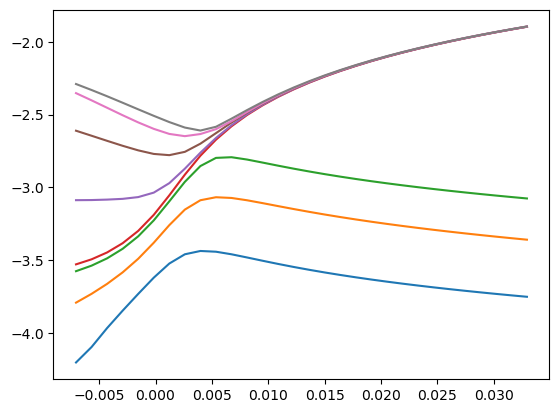

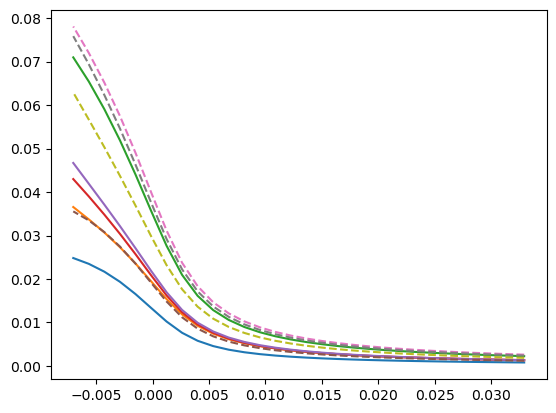

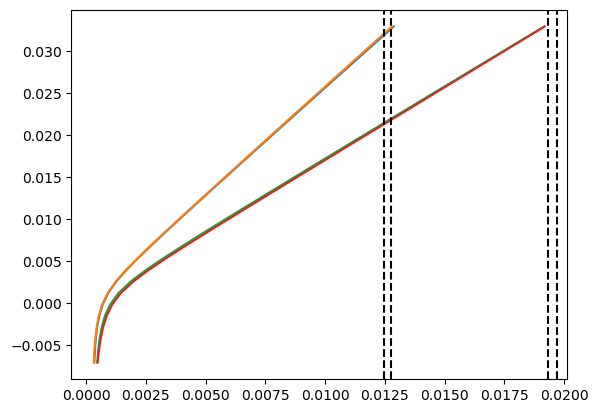

In [39]:
plt.plot(dK2vals,np.log10(freqs))
plt.figure()
plt.plot(dK2vals,eccs)
plt.plot(dK2vals,Z,ls='--')
#plt.axhline(0.026,ls='--',color='k')

Deltas = np.array([(j-1)*p2/p1/j-1 for p2,p1,j in zip(Periods.T[1:],Periods.T[:-1],jres)])

plt.figure()
plt.plot(Deltas.T,dK2vals)
for d in Deltas_obs:
    plt.axvline(d,color='k',ls='--')


In [55]:
15.23351/9.96336 /1.5 - 1

0.019302056066762052

In [42]:
from scipy.interpolate import interp1d


i_eq = np.argmin(np.abs(dK2vals - interp1d(Z[:,0],dK2vals,fill_value='extrapolate')(0.01)))

eqC = eqsC[i_eq]
dK2i = dK2vals[i_eq]
rc.dK2 = dK2i

pvars = rc.real_planar_vars_to_pvars(eqC)
sim_eq = pvars.to_Simulation()
sim_eq.integrator='whfast'
sim_eq.dt = sim_eq.particles[1].P / 25.
Tfin = 15 * Tmax
sim_eq.save_to_file("toi-178",interval=Tfin/256,delete_file=True)
print("integrating...")
sim_eq.integrate(Tfin)

#
print("correcting again...")
pvars = rc.real_planar_vars_to_pvars(eqC)
pvars.values = chi_static.mean_to_osculating_state_vector(rc.real_planar_vars_to_pvars(eqC).values)

sim_eq=pvars.to_Simulation()
sim_eq.integrator='whfast'
sim_eq.dt = sim_eq.particles[1].P / 25.
Tfin = 15 * Tmax
sim_eq.save_to_file("toi-178_cc",interval=Tfin/256,delete_file=True)
print("integrating...")
sim_eq.integrate(Tfin)


integrating...
correcting again...
integrating...


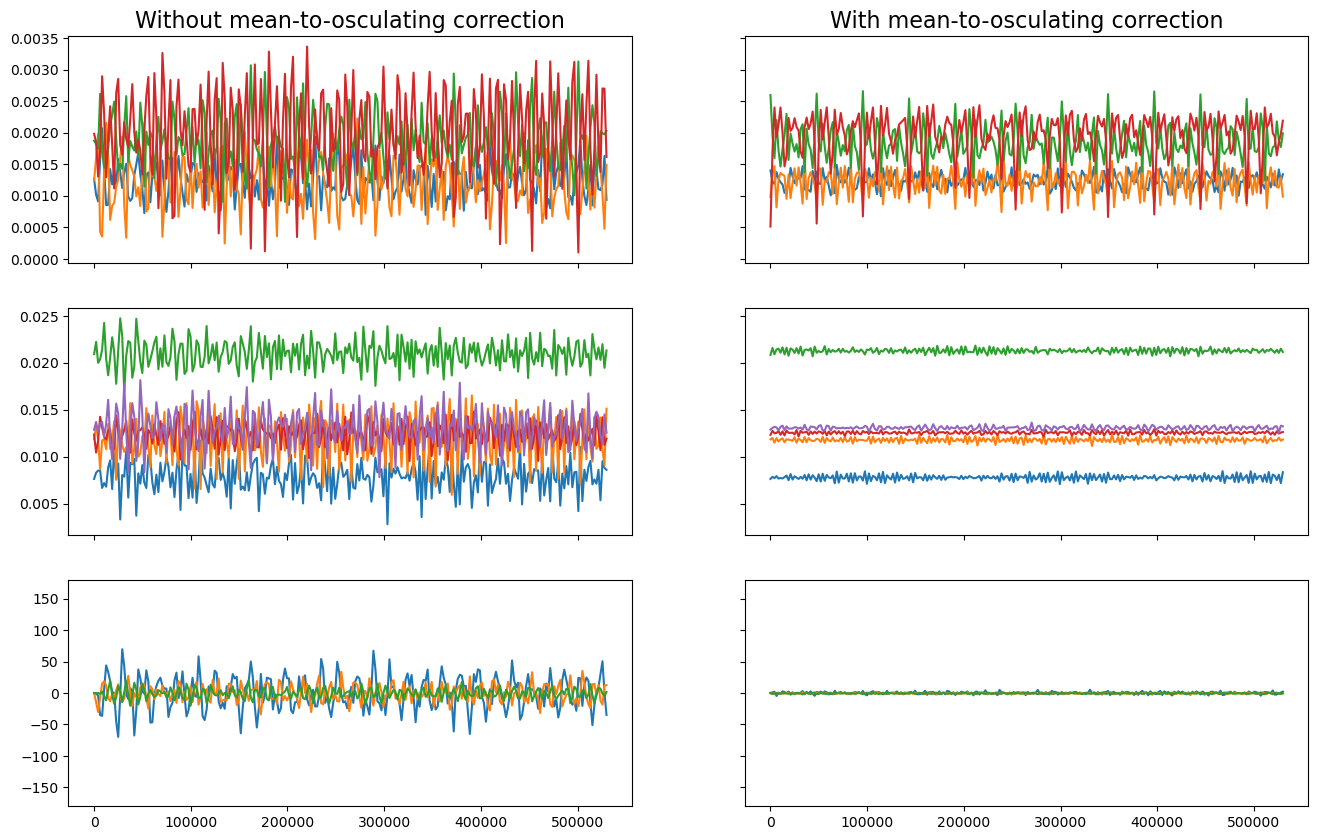

In [43]:
fig,ax_list = plt.subplots(3,2,sharex=True,figsize=(16,10),sharey='row')
ax_list[0,0].set_title("Without mean-to-osculating correction",fontsize=16)
ax_list[0,1].set_title("With mean-to-osculating correction",fontsize=16)
for finame,ax in zip(("kepler-223","kepler-223_cc"),ax_list.T):
    results = cm.nbody_simulation_utilities.get_simarchive_integration_results(finame,coordinates='heliocentric')
    for j,p1,p2 in zip(jres,results['P'][:-1],results['P'][1:]):
        D = (j-1)*p2/p1/j-1
        ax[0].plot(results['time'],D)
    for ecc in results['e']:
        ax[1].plot(results['time'],ecc)

    mymod = lambda x: np.mod(x+np.pi,2*np.pi)-np.pi
    for row in rc.Tmtrx[2:2+rc.M,:rc.N_planar]:
        phi = mymod(row @ results['l'] - (row @ results['l'])[0])
        ax[2].plot(results['time'],180*phi/np.pi)
    ax[2].set_ylim(-180,180)

In [44]:
for eq,finame,dK2 in zip(eqsC,[f"toi-178_sim_dK2_{v:.5f}" for v in dK2vals],dK2vals):
    pvars = rc.real_planar_vars_to_pvars(eq,dK2 = dK2)
    pvars.values = chi_static.mean_to_osculating_state_vector(pvars.values)
    sim=pvars.to_Simulation()
    sim.save_to_file(finame + ".bin",delete_file=True)

In [45]:
import rebound as rb
from matplotlib import pyplot as plt
import celmech as cm

# dissipative dynamics

In [46]:
from resonant_chains import tau_alphas_to_tau_as

In [47]:
def planar_dissipation_jacobian_symbolic(self,X,p=1):
    #
    # X = y_1,...,y_N,kappa_2,phi_1,...,phi_M,x_1,...,x_N,dK2,Phi_1,...,Phi_M
    #
    # dlna/dt = -1/tau_m - 2 p e^2/tau_e

    Ndim = 2*(self.M+self.N_planar+1)
    Npl = self.N_planar
    tau_e = [1/g for g in sp.symbols("gamma_e(1:{})".format(Npl+1),real=True)]
    rho = self.Lambda0s/self.Lambda0s[0]
    dis_jac = np.zeros((Ndim,Ndim),dtype=object)
    D_gamma_a = np.zeros((Npl,Ndim),dtype=object)

    Tinv_transpose = self.Tmtrx_inv.T

    nu_vec = Tinv_transpose[0,:Npl]
    for i in range(Npl):
        i_x = i+Npl+self.M+1
        D_gamma_a[i,i] = 4 * p * X[i] / tau_e[i] / rho[i]
        D_gamma_a[i,i_x] = 4 * p * X[i_x] / tau_e[i] / rho[i]

    K1_by_L10 = nu_vec @ rho
    D_K1_by_L10 = -0.5 * (rho * nu_vec) @ D_gamma_a

    for i,a_i in enumerate(Tinv_transpose[1:self.M+2,:Npl]):   
        i_P = 2 * Npl + self.M + 1 + i
        dis_jac[i_P] += -0.5 * rho * a_i @ D_gamma_a / K1_by_L10
        dis_jac[i_P] += -1 * (a_i @ rho) * D_K1_by_L10 / (K1_by_L10**2)
    dis_jac *= nu_vec @ rho

    i_dK2 = 2 * Npl + self.M+1
    for i in range(Npl):
        gamma_e = 1/tau_e[i]
        dis_jac[i,i] += -1 * gamma_e
        i_x = i+Npl+self.M+1
        dis_jac[i_x,i_x] += -1 * gamma_e
        # dK2
        dis_jac[i_dK2,i] += 2 * gamma_e * X[i]
        dis_jac[i_dK2,i_x] += 2 * gamma_e * X[i_x]
    return dis_jac

In [48]:
i_kappa2 = rc.N_planar 
i_dK2    = 2 * rc.N_planar + rc.M
rc.dK2 = dK2vals[i_eq]

In [49]:
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp

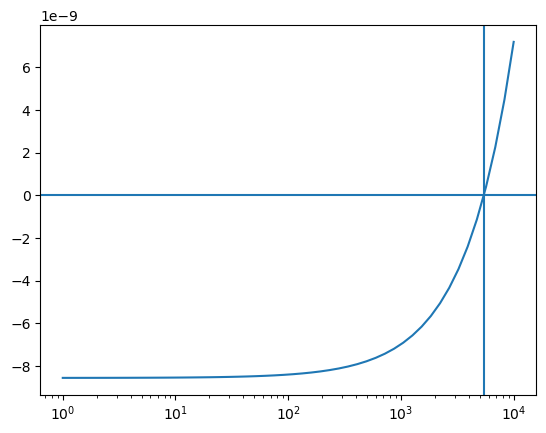

In [60]:
tau_as = np.ones(rc.N_planar) * 1e8
tau_as[0] = np.inf
tau_alphas = 1/(1/tau_as[0]-1/tau_as[1:])
tau_as_new = tau_alphas_to_tau_as(tau_alphas,masses,resonances)

x0 = np.insert(eqsC[i_eq],[-rc.M],[dK2vals[i_eq]])
Kvals=np.geomspace(1,10_000,50)
f_of_K = np.zeros(Kvals.size)
f_of_K_zerop = np.zeros(Kvals.size)
for i,K in enumerate(Kvals):
    tau_es = np.ones(rc.N_planar) * 1e8 / K
    tau_es[1:] = np.inf
    f_of_K[i] = rc.planar_flow_with_dissipation(x0,tau_es,tau_as,1)[-rc.M-1]
plt.plot(Kvals,f_of_K)
plt.axhline(0)
plt.xscale('log')
Keq_estimate = 10**interp1d(f_of_K,np.log10(Kvals))(0)    
tau_es = np.ones(rc.N_planar) * 1e8 / Keq_estimate
tau_es[1:] = np.inf

plt.axvline(Keq_estimate)


In [61]:
tau_alphas = 1/(1/tau_as[0]-1/tau_as[1:])
tau_as_new = tau_alphas_to_tau_as(tau_alphas,masses,resonances)
eq_dis = newton_solve2(
    lambda y: rc.planar_flow_and_jacobian_with_dissipation(y,tau_es,tau_as_new,1),
    x0
)
print((x0[i_dK2]-eq_dis[i_dK2])/x0[i_dK2])
j = rc.planar_jacobian_with_dissipation(eq_dis,tau_es,tau_as_new,1)
eig_rates = np.sort(np.real(np.linalg.eigvals(j)))
Tmax=1/np.max(eig_rates)
Tmax



0.004696303657024139


-4221460.435266886

In [62]:
j_cons = rc.planar_jacobian_with_dissipation(x0,np.inf * tau_es,np.inf * tau_as_new, 1)
vals,vecsT = np.linalg.eig(j_cons)
vecs = vecsT.T
covecs = np.linalg.inv(vecsT)

In [63]:
import numpy as np

def zero_small_values(arr, factor, *, copy=False):
    """
    Zero-out entries that are a given factor smaller (in absolute value)
    than the largest magnitude element in a NumPy array.

    Parameters
    ----------
    arr : np.ndarray
        Input array (any shape, real or complex).
    factor : float
        Threshold factor in (0, 1].  Elements whose absolute value is
        strictly less than ``factor * max(abs(arr))`` are set to zero.
        • factor = 1   ➔ only the maximum-magnitude element is kept  
        • factor ≈ 0  ➔ almost everything is kept
    copy : bool, optional
        If ``True`` return a modified *copy* and leave the original
        unchanged.  If ``False`` (default) the operation is in-place.

    Returns
    -------
    np.ndarray
        The thresholded array (same object as ``arr`` unless ``copy=True``).

    Example
    -------
    >>> x = np.array([1e-3, 2, -0.5, 10])
    >>> zero_small_values(x, 0.1)        # in-place
    >>> x
    array([0.   , 2.   , 0.   , 10.  ])
    """
    if not (0 < factor <= 1):
        raise ValueError("factor must be in the interval (0, 1].")

    target = arr.copy() if copy else arr
    max_abs = np.abs(target).max()          # largest magnitude
    cutoff  = factor * max_abs
    mask    = np.abs(target) < cutoff
    target[mask] = 0
    return target


$\tau_\mathrm{wave} = \frac{M_*}{m_p}\frac{M_*}{\Sigma a_p^2}h^4n_p^{-1}$

In [64]:
chain_sim = get_chain_rebound_sim(resonances,masses)

In [67]:
j_dis_symb = planar_dissipation_jacobian_symbolic(
    rc,
    np.insert(x0,i_kappa2,0)
)
j_dis_symb = np.delete(np.delete(j_dis_symb,i_kappa2,axis=0),i_kappa2,axis=1)

sigma = -1.5
gamma_wave = np.array([p.m * p.a**(2+sigma) * p.n for p in chain_sim.particles[1:]])
gamma_wave /= gamma_wave[0]
gamma_wave

for vec,vec_c,covec,val in zip(vecs[::2],vecs[1::2],covecs[::2],vals[::2]):
    exprn = sp.re(covec@j_dis_symb@vec)
    coeffs = np.array([exprn.coeff(g) for g in sp.symbols("gamma_e(1:{})".format(Npl+1),real=True)],dtype=float)
    zero_small_values(coeffs,1e-3)
    if np.any(coeffs>0):
        
        print("{:.5f}".format(np.imag(val)))
        print(np.array2string(coeffs,precision=3))
        angle_amps = np.real(vec[rc.N_planar:rc.N_planar+rc.M]+vec_c[rc.N_planar:rc.N_planar+rc.M])
        print(np.array2string(angle_amps,precision=3))
        rate_typeI = gamma_wave @ coeffs
        print("{:.5f}".format(rate_typeI))
        print()

0.00257
[-0.007  0.001 -0.014 -0.019 -0.013]
[-1.333  1.445 -0.365]
-0.02679

0.00225
[-0.004  0.001 -0.035 -0.016 -0.227]
[-1.564  0.633  0.977]
-0.08405

0.00175
[-0.081  0.004 -0.147 -0.157 -0.029]
[ 1.91   0.486 -0.331]
-0.23698

0.00035
[-0.256  0.006 -0.087 -0.116 -0.079]
[-1.969 -0.327 -0.122]
-0.37646



# choose $\tau_e\propto \tau_\mathrm{wave}$

In [38]:
Tmax/1e7

0.5782139559823394

600220.5408692237

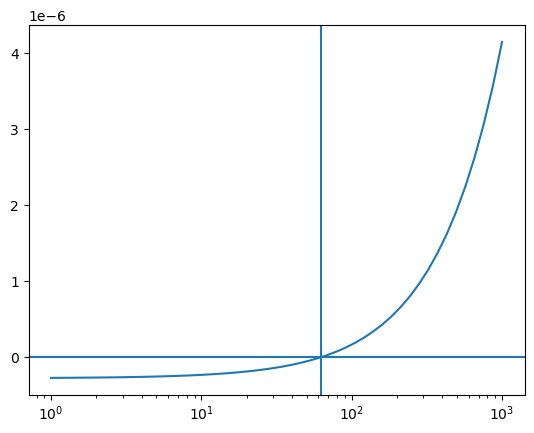

In [39]:
gamma_wave

tau_as = np.ones(rc.N_planar) * 1e6
tau_as[0] = np.inf
tau_alphas = 1/(1/tau_as[0]-1/tau_as[1:])
tau_as_new = tau_alphas_to_tau_as(tau_alphas,masses,resonances)

x0 = np.insert(eqsC[i_eq],[-rc.M],[dK2vals[i_eq]])
Kvals=np.geomspace(1,1_000,50)
f_of_K = np.zeros(Kvals.size)
f_of_K_zerop = np.zeros(Kvals.size)
for i,K in enumerate(Kvals):
    tau_es =  1e6 / K / gamma_wave
    f_of_K[i] = rc.planar_flow_with_dissipation(x0,tau_es,tau_as,1)[-rc.M-1]
plt.plot(Kvals,f_of_K)
Keq_estimate = 10**interp1d(f_of_K,np.log10(Kvals))(0)    

tau_es = 1e6 / Keq_estimate / gamma_wave


plt.axvline(Keq_estimate)
plt.axhline(0)
plt.xscale('log')


eq_dis = newton_solve2(
    lambda y: rc.planar_flow_and_jacobian_with_dissipation(y,tau_es,tau_as_new,1),
    x0
)
assert np.isclose(x0[i_dK2],eq_dis[i_dK2],rtol=1e-2)
j = rc.planar_jacobian_with_dissipation(eq_dis,tau_es,tau_as_new,1)
eig_rates = np.sort(np.real(np.linalg.eigvals(j)))
Tmax=1/np.max(eig_rates)
Tmax



In [42]:
tau_as_new,tau_es

(array([-1630015.53936419,  2587262.43643006,  2587262.43643006,
         2587262.43643006]),
 array([16028.28057524, 28171.29756299, 23531.52651953, 47506.97337476]))

In [ ]:
import reboundx as rbx

pv = rc.real_planar_vars_to_pvars(
    np.delete(eq_dis,-rc.M-1),
    dK2=eq_dis[-rc.M-1]
)
sim = pv.to_Simulation()
extras = rbx.Extras(sim)
mod = extras.load_operator('modify_orbits_direct')
mod.params['p']=1
extras.add_operator(mod)
for tau_e,tau_a,p in zip(tau_es,tau_as_new,sim.particles[1:]):
    p.params['tau_e'] = -1*tau_e
    p.params['tau_a'] = -1*tau_a
sim.integrator='whfast'
sim.dt = sim.particles[1].P/30
Tfin = 5 * Tmax

sim.save_to_file("kepler-223_migration.sa",interval = Tfin  / 512,delete_file = True)
sim.integrate(Tfin)

In [47]:
results = cm.nbody_simulation_utilities.get_simarchive_integration_results(
    "kepler-223_migration.sa",
    coordinates='heliocentric'
)

(-180.0, 180.0)

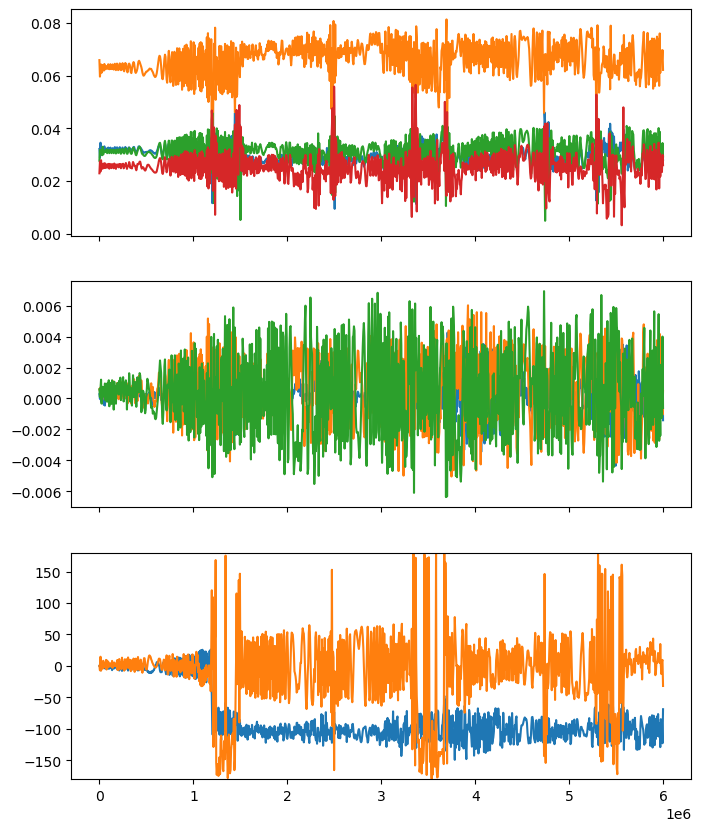

In [48]:
fig,ax = plt.subplots(3,1,sharex=True,figsize=(8,10))

for i in range(rc.N_planar):
    ax[0].plot(results['time'],results['e'][i])

for i in range(rc.N_planar-1):
    P1,P2 = results['P'][i],results['P'][i+1]
    j = resonances[i][0]
    Delta = (j-1)*P2/P1/j - 1
    ax[1].plot(results['time'],Delta)
    
for i in range(rc.M):
    phi = rc.Tmtrx[2+i,:rc.N_planar]@results['l']
    phi0 = eq_dis[rc.N_planar+i]
    phi = mymod(phi - phi0)
    ax[2].plot(results['time'],180*phi/np.pi)
ax[2].set_ylim(-180,180)